In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime, timedelta

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [26]:
model_name = 'ecmwfsipn'
model_type = 'forecast'
no_day_change = 5


filepath_save = '/home/disk/sipn/mcmcgraw/data/VRILE/'
filename_full = filepath_save+'{model_name}_{model_type}_2018_TEST_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                       model_type=model_type,d_days=no_day_change)
d_SIE = pd.read_csv(filename_full)
d_SIE_all = d_SIE.dropna()

In [27]:
regions = d_SIE_all['region'].unique().tolist() #list unique regions
lead_days = d_SIE_all['lead time (days)'].unique().tolist()
#print(lead_days)
#ds_SIC_all.head()
#toggle for SIE or change in SIE
choose_var_model = 'SIE'
choose_var_obs = 'SIE'
titlename_choose_var = 'Sea ice extent'
filename_choose_var = 'SIE'
model_yr = pd.to_datetime(d_SIE_all['V (valid date)']).dt.year
yr_sel = 2018
f_yr_model = np.where(model_yr==yr_sel)
ds_SIC_all = d_SIE_all.loc[f_yr_model]
ds_SIC_all.head()

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Unnamed: 0,I (init date),V (valid date),V_mon (valid date month),V_yr (valid date year),SIE,lead time (days),d_SIC (V - I),ensemble,region
59,0.0,2017-11-01,2018-01-01 00:00:00,1.0,2018.0,1.122888,61.0,0.0,1.0,Hudson Bay
60,0.0,2017-11-01,2018-01-02 00:00:00,1.0,2018.0,1.122888,62.0,0.0,1.0,Hudson Bay
61,0.0,2017-11-01,2018-01-03 00:00:00,1.0,2018.0,1.122888,63.0,0.0,1.0,Hudson Bay
62,0.0,2017-11-01,2018-01-04 00:00:00,1.0,2018.0,1.122888,64.0,0.0,1.0,Hudson Bay
63,0.0,2017-11-01,2018-01-05 00:00:00,1.0,2018.0,1.122888,65.0,0.0,1.0,Hudson Bay


Initialize dataframe to keep track of bias.  Bias is defined as Model - Obs.  So a negative value means model SIE is less than observed; positive value means model SIE is greater than observed. 


In [28]:
mons_vec = np.arange(1,13)
mon_tile = np.tile(mons_vec,len(regions))
df_bias = pd.DataFrame(columns=['SIE bias','month','region'])
df_bias['month'] = mon_tile

fpath_save_im = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/sea_ice_seas_cycle/'

Load observations from NSIDC 

In [46]:
#%% Load obs
obs_name = 'NSIDC_0079'
obs_type = 'sipn_nc_yearly_agg'
obs_filename = '/home/disk/sipn/mcmcgraw/data/VRILE/{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=obs_name,
                       model_type=obs_type,d_days=no_day_change)
SIE_obs = pd.read_csv(obs_filename)
SIE_obs = SIE_obs.dropna()
SIE_obs.head()
obs_yr = pd.to_datetime(SIE_obs['V (valid date)']).dt.year
obs_mon = pd.to_datetime(SIE_obs['V (valid date)']).dt.month
obs_valid = pd.to_datetime(SIE_obs['V (valid date)'])
#yr_sel = 2018
yr_vec = np.arange(yrmin,yrmax)
f_yr_obs = np.where(obs_yr==yr_sel) 
SIE_obs_trim = SIE_obs.loc[f_yr_obs]

In [48]:

#reg_ind_sel = 0
#region_sel = regions[reg_ind_sel]
region_sel = 'panArctic'
#bias_save_ind = reg_ind_sel*12 + np.arange(0,12)
#df_bias.loc[bias_save_ind,'region'] = region_sel
#print(df_bias)
print('running region {region}'.format(region=region_sel))
SIC_reg_group = ds_SIC_all.groupby(['region'])
SIC_reg_sel = SIC_reg_group.get_group(region_sel)
#Now group by lead time
lead_ind_sel = 2
SIC_lead_group = SIC_reg_sel.groupby(['lead time (days)'])
SIC_lead_sel = SIC_lead_group.get_group(lead_ind_sel)
SIC_lead_sel

running region panArctic


,Unnamed: 0,I (init date),V (valid date),V_mon (valid date month),V_yr (valid date year),SIE,lead time (days),d_SIC (V - I),ensemble,region
32895,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,12.006032,2.0,0.248876,1.0,panArctic
33106,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,11.942170,2.0,0.216999,2.0,panArctic
33317,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,12.055502,2.0,0.214383,3.0,panArctic
33528,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,11.976103,2.0,0.198601,4.0,panArctic
33739,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,12.058861,2.0,0.274593,5.0,panArctic
33950,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,11.982141,2.0,0.283779,6.0,panArctic
34161,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,11.938454,2.0,0.235087,7.0,panArctic
34372,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,12.070884,2.0,0.195849,8.0,panArctic
34583,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,11.970656,2.0,0.188731,9.0,panArctic
34794,0.0,2018-01-01,2018-01-03 00:00:00,1.0,2018.0,12.027635,2.0,0.227290,10.0,panArctic


Seasonal cycle (group by valid dates)

In [57]:
valid_dates = pd.to_datetime(SIC_lead_sel['V (valid date)'])
valid_dates_month = pd.to_datetime(SIC_lead_sel['V (valid date)']).dt.month
SIC_mon_sel = SIC_lead_sel
SIC_mon_sel['valid date month'] = valid_dates_month
SIC_mon_sel_valid = SIC_mon_sel['V (valid date)']

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plot seasonal cycle of model data--this looks better than the reforecasts (although it's only one year)

Text(0.5, 1.0, '2018 Sea ice extent, panArctic (ecmwfsipn forecast), lead days: 2')

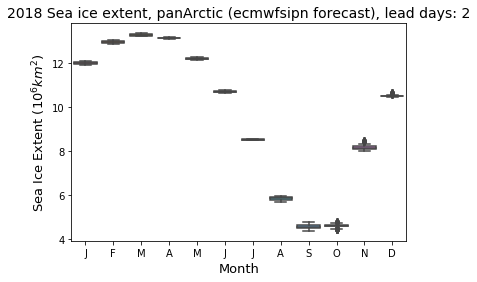

In [50]:
import seaborn as sns

SIC_mon_group = SIC_mon_sel.groupby(['valid date month'])
fig1 = plt.figure(1)
ax1=sns.boxplot(x='valid date month',y=choose_var_model,data=SIC_mon_sel)
ax1.set_xlabel('Month',fontsize=13)
ax1.set_ylabel('Sea Ice Extent ($10^6 km^2$)',fontsize=13)
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.set_title('{yr_choose} {title_var}, {region} ({model_name} {model_type}), lead days: {lead_day}'.format(yr_choose=yr_sel,title_var=titlename_choose_var,
              region=region_sel,
              model_name=model_name,model_type=model_type,lead_day=lead_ind_sel),fontsize=14)

Now put obs and model side by side.  First group model data by region and date

In [84]:
SIE_obs_reg = SIE_obs_trim.groupby(['region'])
SIE_obs_reg_sel = SIE_obs_reg.get_group(region_sel)
print('running region {region}'.format(region=region_sel))
SIE_obs_mon = SIE_obs_reg_sel.groupby(['V (valid date)'])
SIC_mod_dates = pd.to_datetime(SIC_mon_sel['V (valid date)']).dt.date.unique()
SIC_obs_dates = pd.to_datetime(SIE_obs_reg_sel['V (valid date)']).dt.date
SIC_obs_save = np.empty([])

#print(SIC_mon_sel_valid.values == SIE_obs_reg_sel['V (valid date)'])
#print(f_obs_sel)
SIE_obs_mon_mean = SIE_obs_mon.mean()
stat = 'mean'
#print(SIE_obs_mon_mean)
SIE_seas = SIE_obs_mon_mean[choose_var_obs]
print(SIC_obs_dates)

running region panArctic
10590    2018-01-01
10591    2018-01-02
10592    2018-01-03
10593    2018-01-04
10594    2018-01-05
10595    2018-01-06
10596    2018-01-07
10597    2018-01-08
10598    2018-01-09
10599    2018-01-10
10600    2018-01-11
10601    2018-01-12
10602    2018-01-13
10603    2018-01-14
10604    2018-01-15
10605    2018-01-16
10606    2018-01-17
10607    2018-01-18
10608    2018-01-19
10609    2018-01-20
10610    2018-01-21
10611    2018-01-22
10612    2018-01-23
10613    2018-01-24
10614    2018-01-25
10615    2018-01-26
10616    2018-01-27
10617    2018-01-28
10618    2018-01-29
10619    2018-01-30
            ...    
10923    2018-11-30
10924    2018-12-01
10925    2018-12-02
10926    2018-12-03
10927    2018-12-04
10928    2018-12-05
10929    2018-12-06
10930    2018-12-07
10931    2018-12-08
10932    2018-12-09
10933    2018-12-10
10934    2018-12-11
10935    2018-12-12
10936    2018-12-13
10937    2018-12-14
10938    2018-12-15
10939    2018-12-16
10940    2018-1

Text(0.5, 1.0, '2018 Sea ice extent, Barents Sea, lead days: 2')

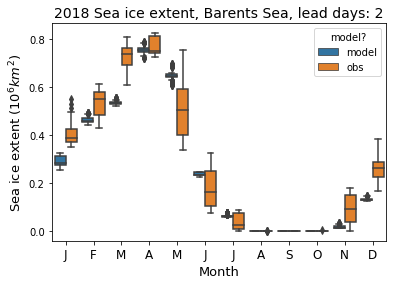

In [45]:
model_double_plot = pd.DataFrame(columns=['SIE','month','model?'])
model_double_plot['SIE'] = SIC_mon_sel[choose_var_model]
model_double_plot['month'] = SIC_mon_sel['valid date month']
model_double_plot['model?'] = 'model'

obs_double_plot = pd.DataFrame(columns=['SIE','month','model?'])
obs_double_plot['SIE'] = SIE_obs_reg_sel[choose_var_obs]
obs_double_plot['month'] = SIE_obs_reg_sel['V_mon (valid date month)'].astype(np.int64)
obs_double_plot['model?'] = 'obs'

df_double_plot = pd.concat([model_double_plot,obs_double_plot],axis=0)
fig5 = plt.figure(5)
ax5 = sns.boxplot(x='month',y='SIE',hue='model?',data=df_double_plot)
ax5.set_xlabel('Month',fontsize=13)
ax5.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize=12)
ax5.set_ylabel('Sea ice extent ($10^6 km^2$)',fontsize=13)
ax5.set_title('{yr_sel} {titlename}, {region}, lead days: {lead_day}'.format(yr_sel=yr_sel,titlename=titlename_choose_var,
              region=region_sel,lead_day=lead_ind_sel),fontsize=14)